## Pycon 2017 
 - 이상열 Speaker님의 Github 내용을 따라한 자료.
 - 참조 pycon 2017

In [99]:
import os
import sys
import operator
import numpy as np
import pandas as pd
from scipy import sparse
import xgboost as xgb
import random
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.preprocessing import Imputer

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set(style='ticks') #http://seaborn.pydata.org/tutorial/color_palettes.html
color = sns.color_palette()

%matplotlib inline 

In [100]:
import datetime as dt

In [101]:
from pylab import rcParams
rcParams['figure.figsize'] = 8,5

## Data Loading

In [102]:
train_df = pd.read_json('data/train.json')
test_df = pd.read_json('data/test.json')

In [103]:
train_df.shape

(49352, 15)

In [104]:
test_df.shape

(74659, 14)

In [105]:
train_df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


In [106]:
test_df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street
1,1.0,2,0,2016-06-24 06:36:34,Prime Soho - between Bleecker and Houston - Ne...,Thompson Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7278,7210040,-74.0000,d0b5648017832b2427eeb9956d966a14,[https://photos.renthop.com/2/7210040_d824cc71...,2850,176 Thompson Street
100,1.0,1,3dbbb69fd52e0d25131aa1cd459c87eb,2016-06-03 04:29:40,New York chic has reached a new level ...,101 East 10th Street,"[Doorman, Elevator, No Fee]",40.7306,7103890,-73.9890,9ca6f3baa475c37a3b3521a394d65467,[https://photos.renthop.com/2/7103890_85b33077...,3758,101 East 10th Street
1000,1.0,2,783d21d013a7e655bddc4ed0d461cc5e,2016-06-11 06:17:35,Step into this fantastic new Construction in t...,South Third Street\r,"[Roof Deck, Balcony, Elevator, Laundry in Buil...",40.7109,7143442,-73.9571,0b9d5db96db8472d7aeb67c67338c4d2,[https://photos.renthop.com/2/7143442_0879e9e0...,3300,251 South Third Street\r
100000,2.0,2,6134e7c4dd1a98d9aee36623c9872b49,2016-04-12 05:24:17,"~Take a stroll in Central Park, enjoy the ente...","Midtown West, 8th Ave","[Common Outdoor Space, Cats Allowed, Dogs Allo...",40.7650,6860601,-73.9845,b5eda0eb31b042ce2124fd9e9fcfce2f,[https://photos.renthop.com/2/6860601_c96164d8...,4900,260 West 54th Street


In [107]:
col_train = train_df.columns
col_test = test_df.columns

In [108]:
col_train.difference(col_test) # interset_level is what we want to know

Index(['interest_level'], dtype='object')

In [109]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 10 to 99994
Data columns (total 15 columns):
bathrooms          49352 non-null float64
bedrooms           49352 non-null int64
building_id        49352 non-null object
created            49352 non-null object
description        49352 non-null object
display_address    49352 non-null object
features           49352 non-null object
interest_level     49352 non-null object
latitude           49352 non-null float64
listing_id         49352 non-null int64
longitude          49352 non-null float64
manager_id         49352 non-null object
photos             49352 non-null object
price              49352 non-null int64
street_address     49352 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


In [110]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74659 entries, 0 to 99999
Data columns (total 14 columns):
bathrooms          74659 non-null float64
bedrooms           74659 non-null int64
building_id        74659 non-null object
created            74659 non-null object
description        74659 non-null object
display_address    74659 non-null object
features           74659 non-null object
latitude           74659 non-null float64
listing_id         74659 non-null int64
longitude          74659 non-null float64
manager_id         74659 non-null object
photos             74659 non-null object
price              74659 non-null int64
street_address     74659 non-null object
dtypes: float64(3), int64(3), object(8)
memory usage: 8.5+ MB


## Data description

In [111]:
train_df.iloc[0][:]

bathrooms                                                        1.5
bedrooms                                                           3
building_id                         53a5b119ba8f7b61d4e010512e0dfc85
created                                          2016-06-24 07:54:24
description        A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...
display_address                                  Metropolitan Avenue
features                                                          []
interest_level                                                medium
latitude                                                     40.7145
listing_id                                                   7211212
longitude                                                   -73.9425
manager_id                          5ba989232d0489da1b5f2c45f6688adc
photos             [https://photos.renthop.com/2/7211212_1ed4542e...
price                                                           3000
street_address                    

In [112]:
 train_df.iloc[2][['display_address','street_address']]

display_address        W 13 Street
street_address     241 W 13 Street
Name: 100004, dtype: object

 - description: 게시자의 소개글
 - features: a list of features about this apartment

In [113]:
train_df.iloc[2]['description']

'Top Top West Village location, beautiful Pre-war building with laundry in the basement and live in super!<br/><br/>Apartment features a large bedroom with closet. Separate living room, kitchen features granite tops, dishwasher and microwave included, marble bathroom and hardwood flooring. Building is very well maintained and conveniently located near A,C,E,L,1,2,3 trains. Surrounded by many local cafe?s, restaurants, available for November 1st move in!<br/><br/>To view this apartment or any other please contact me via email or call at the number listed.<br/><br/><br/><br/><br/><br/>Bond New York is a real estate broker that supports equal housing opportunity.<p><a  website_redacted '

In [114]:
train_df.iloc[2]['features']

['Laundry In Building',
 'Dishwasher',
 'Hardwood Floors',
 'Pets Allowed Case by Case']

In [115]:
train_df.iloc[2]['photos']

['https://photos.renthop.com/2/6887163_de85c427363a2e6d736a5df96d8d5541.jpg',
 'https://photos.renthop.com/2/6887163_b9cf6db6df611bc53f75be3214a43807.jpg',
 'https://photos.renthop.com/2/6887163_cd3f2246cfd25691f33ed12b251d0230.jpg',
 'https://photos.renthop.com/2/6887163_54c402cf0d681f6ea4796b9d177786bb.jpg',
 'https://photos.renthop.com/2/6887163_7745da2a3693fe627154794ab0ebca29.jpg',
 'https://photos.renthop.com/2/6887163_95c93e4af27182f8ac55c749fc74a041.jpg',
 'https://photos.renthop.com/2/6887163_4b50a743b760e23b8d6f6f586a704da7.jpg',
 'https://photos.renthop.com/2/6887163_6133523d6d5a0fba36bb25e3616848c8.jpg']

In [116]:
train_df['interest_level'].unique().tolist() # 3 Levels

['medium', 'low', 'high']

## 탐색적분석(EDA)

### 2-1 Interest_level

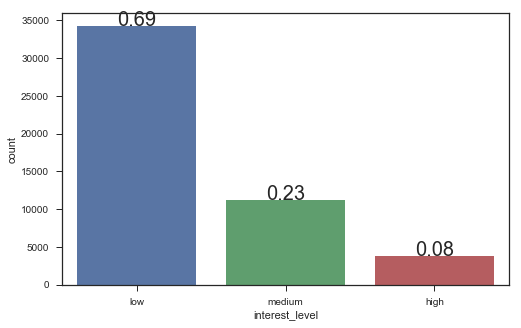

In [117]:
ax = sns.countplot(x="interest_level", data=train_df, order=['low','medium','high'])
total = float(len(train_df))

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height+3, 
            '{:1.2f}'.format(height/total),
            size=20, ha='center')

 - interest_level은 69% Low, 23% Medium, 8% high
 - 모델 학습할 때 클래스 간의 비율을 맞추기 위해서 Oversampling / undersampling 필요할 수 있음 

### 2-2 Price

In [118]:
train_df.groupby(['interest_level']).mean()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
interest_level,,,,,,
high,1.116176,1.546496,40.748007,7.017844e+06,-73.964613,2700.293045
low,1.238741,1.514759,40.739504,7.026373e+06,-73.951667,4176.599142
medium,1.163906,1.622050,40.745567,7.019098e+06,-73.965033,3158.767388


[(0, 300000)]

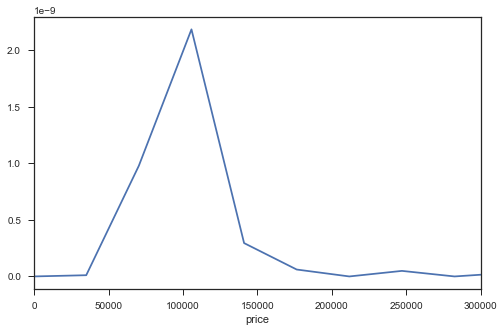

In [119]:
sns.distplot(train_df['price'], hist=False).set(xlim=(0, 300000))

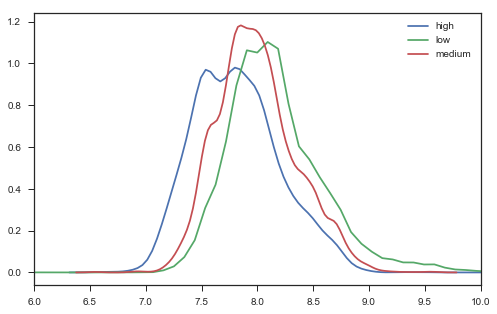

In [120]:
for l, g in train_df.groupby('interest_level'):
    sns.kdeplot(np.log(g['price']), label=l, cumulative=False).set(xlim=(6,10))

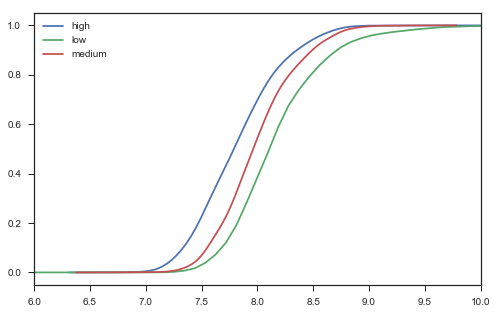

In [121]:
for l, g in train_df.groupby('interest_level'):
    sns.kdeplot(np.log(g['price']), label=l, cumulative=True).set(xlim=(6,10))

 - 가격이 낮을수록 interest level이 높다.

### 2-3 bathrooms

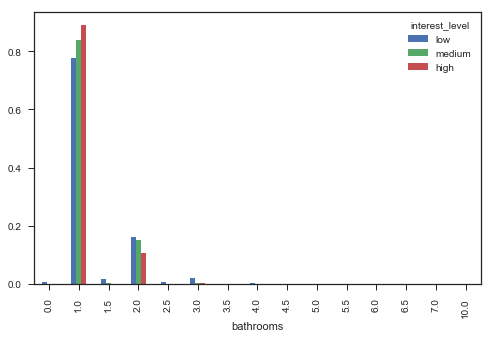

In [122]:
bathrooms = train_df.groupby(['bathrooms','interest_level'])['bathrooms'].count().unstack('interest_level')
bathrooms /= bathrooms.sum()
bathrooms.fillna(0)[['low','medium','high']].plot(kind='bar')

 - 화장실은 대체로 1개이고 침실은 0-2개인 경우가 많다.
 - 화장실이 1개인 경우 상대적으로 관심도가 높고, 화장실이 많을 수록 관심도가 낮다.=> 가격에 비례하게 화장실 수가 많을 것으로 예상된다. 

In [123]:
train_df[['bedrooms','bathrooms','price']].corr() # -> 상관계수가 낮다. 크게 관계가 없는 것으로 나온다. 

,bedrooms,bathrooms,price
bedrooms,1.000000,0.533446,0.051788
bathrooms,0.533446,1.000000,0.069661
price,0.051788,0.069661,1.000000


In [124]:
train_df.corr()['price'] ## 그나마 관계가 높은 것이 화장실이랑 침실 수다.

bathrooms     0.069661
bedrooms      0.051788
latitude     -0.000707
listing_id    0.008090
longitude    -0.000087
price         1.000000
Name: price, dtype: float64

In [125]:
np.cumsum(bathrooms.fillna(0))

interest_level,high,low,medium
bathrooms,,,
0.0,0.000260,0.008925,0.000534
1.0,0.889294,0.784243,0.840146
1.5,0.889294,0.801890,0.843708
2.0,0.995311,0.964240,0.993944
2.5,0.995311,0.972232,0.994211
3.0,0.998958,0.991804,0.999555
3.5,0.998958,0.993846,0.999555
4.0,1.000000,0.998221,1.000000
4.5,1.000000,0.999067,1.000000


[(0, 1), (0, 3)]

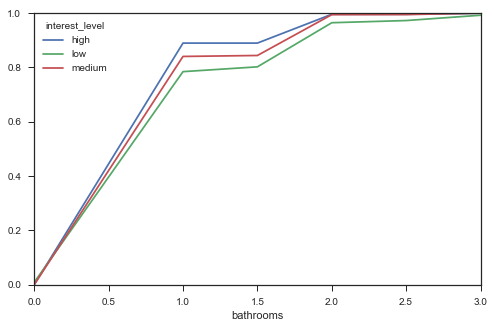

In [126]:
np.cumsum(bathrooms.fillna(0)).plot(kind='line').set(xlim=(0,3), ylim=(0,1))

### 2-4 Bedrooms 

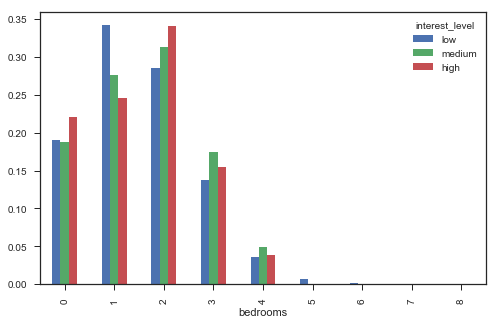

In [127]:
bedrooms = train_df.groupby(['bedrooms', 'interest_level'])['bedrooms'].count().unstack('interest_level')
bedrooms /= bedrooms.sum()
bedrooms[['low', 'medium', 'high']].plot(kind='bar')

[(0, 1), (0, 4)]

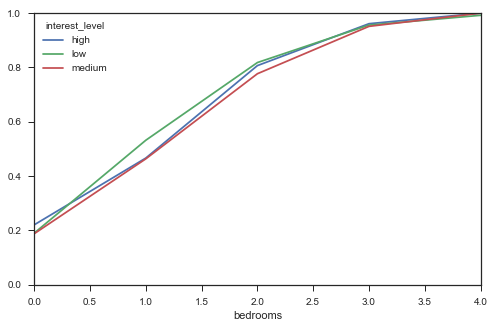

In [128]:
np.cumsum(bedrooms.fillna(0)).plot(kind='line').set(xlim=(0,4), ylim=(0,1))

### 2-5 Created 

In [129]:
train_df['created'] = pd.to_datetime(train_df['created'])
train_df['week'] = train_df['created'].dt.week
train_df['hour'] = (train_df['created'].dt.hour - 5) % 24 # 동부 표준시는 UTC-05:00 이다.
train_df['weekday'] = train_df['created'].dt.weekday

test_df['created'] = pd.to_datetime(test_df['created'])
test_df['week'] = test_df['created'].dt.week
test_df['hour'] = (test_df['created'].dt.hour - 5) % 24 # 동부 표준시는 UTC-05:00 이다.
test_df['weekday'] = test_df['created'].dt.weekday

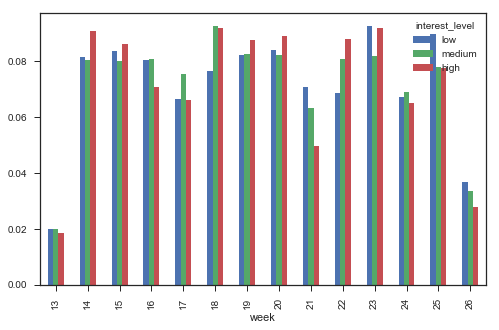

In [130]:
weeks = train_df.groupby(['week','interest_level'])['week'].count().unstack()
weeks /= weeks.sum()
weeks[['low','medium','high']].plot(kind='bar')

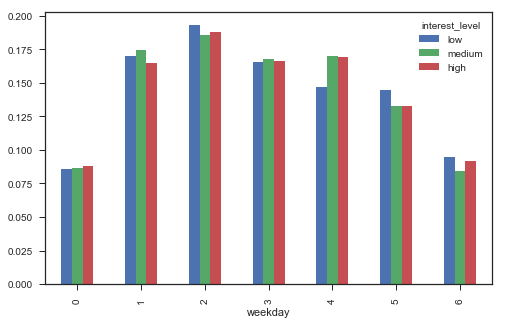

In [131]:
weekdays = train_df.groupby(['weekday','interest_level'])['weekday'].count().unstack()
weekdays /= weekdays.sum()
weekdays[['low','medium','high']].plot(kind='bar')

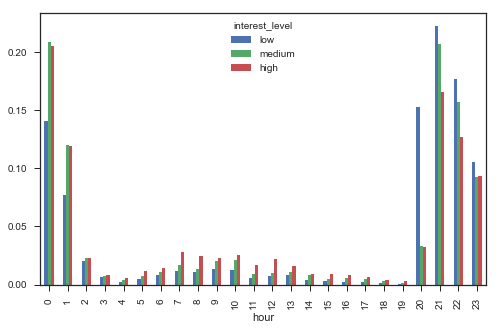

In [132]:
hours = train_df.groupby(['hour', 'interest_level'])['hour'].count().unstack('interest_level').fillna(0)
hours /= hours.sum()
hours[['low', 'medium', 'high']].plot(kind='bar')

[(0, 23)]

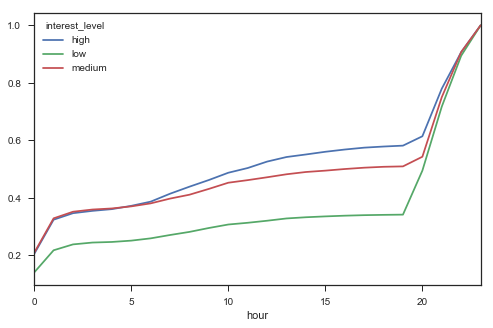

In [133]:
np.cumsum(hours.fillna(0)).plot(kind='line').set(xlim=(0,23))

### 2-6 photos, features & description

In [134]:
train_df.loc[:, 'num_photos'] = train_df.loc[:, 'photos'].apply(len)
train_df.loc[:, 'num_features'] = train_df.loc[:, 'features'].apply(len)
train_df.loc[:, 'num_words'] = train_df.loc[:, 'description'].apply(lambda x: len(x.split(' ')))

test_df.loc[:, 'num_photos'] = test_df.loc[:, 'photos'].apply(len)
test_df.loc[:, 'num_features'] = test_df.loc[:, 'features'].apply(len)
test_df.loc[:, 'num_words'] = test_df.loc[:, 'description'].apply(lambda x: len(x.split(' ')))

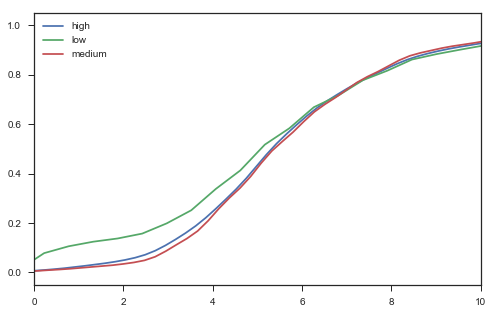

In [135]:
for l, g in train_df.groupby('interest_level'):
    sns.kdeplot(g['num_photos'], label=l, cumulative = True).set(xlim=(0, 10))

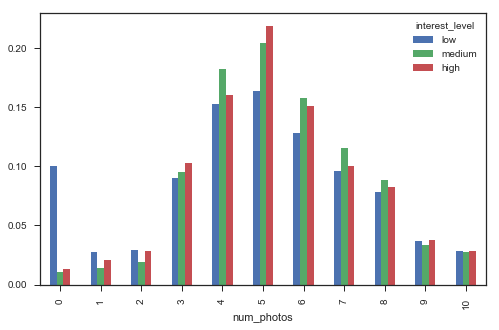

In [136]:
photos = train_df.groupby(['num_photos', 'interest_level'])['num_photos'].count().unstack('interest_level').fillna(0)
photos /= photos.sum()
photos.ix[:10, ['low', 'medium', 'high']].plot(kind='bar')
plt.show()